# Parameterisation, Molecular Dynamics, and Trajectory Analysis of a Protein-Ligand Complex with OpenFF, OpenMM, and MDTraj

Note: This is heavily lifted from the [toolkit showcase](https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-toolkit/toolkit_showcase/toolkit_showcase.html) example.

This notebook demonstrates how to prepare a system that combines solvent, a ligand using Sage, and a protein using a standard Amber force field. We'll take the structures of the MCL-1 and the bound ligand from the crystal structure (TODO: ADD and prepare), but we could just as easily use a ligand pose from docking. We'll solvate the complex, assemble the system, parameterise it, and finally simulate it with OpenMM and visualize the results, all without leaving the notebook. Have fun!

## The plan:

| Action | Software|
|--|--|
| Assemble the topology | OpenFF Toolkit
| Visualize the complex | OpenFF Toolkit and NGLView
| Parametrize the complex | OpenFF Toolkit and OpenFF Interchange
| Simulate the complex | OpenMM
| Visualize the simulation | NGLView and MDTraj


TODO: Add outline with clickable sections and clear workflow, clearly acknowledge where/ who material was taken from (mainly previous workshop), add jupyter cheat sheet...

TODO: Format the boxes consistently with the last tutorial

TODO: Add a load of exercises

## 1. We Can Visualise the Protein and Ligand with NGLView

We'll be using the MCL-1 complex with PDBID `6o6f`. This is a common system for benchmarking protein-ligand binding free energy calcalulations and features in the [protein-ligand benchmark set hosted by OpenFF](https://github.com/openforcefield/protein-ligand-benchmark).

As we've already covered structure preparation, we provide pre-prepared protein and ligand structures in the `structures` directory. These are ready for simulation:

- Their co-ordinates are super-imposable (and there are no clashes between waters and the ligand)
- Hydrogens have been added to protein and crystallographic waters consistent with pH 7
- The protein's termini have been capped where appropriate to prevent unphysical charges
- A missing residue in the middle of the chain has been added
- The protein has been solvated and 150 mM NaCl added
- The overall system is neutral

If you'd like more information on how this was done, check out `structures/README.md`.

In [ ]:
receptor_path = "../structures/6o6f_protein_solvated.pdb"
ligand_path = "../structures/6o6f_ligand.sdf"

We can visualize each structure using the [NGLView] widget. These visualizations are interactive; rotate by dragging the left mouse button, pan with the right mouse button, and zoom with the scroll wheel. You can also mouse over an atom to see its details, and click an atom to center the view on it. When you mouse over the widget, a full screen button will appear in its top right corner.

[NGLView]: https://github.com/nglviewer/nglview

In [114]:
import nglview

view = nglview.show_structure_file(ligand_path)
view

NGLWidget()

<div class="alert alert-info" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    ℹ️ Try replacing <code>ligand_path</code> with <code>receptor_path</code> to visualize the protein!
</div>


## 2. OpenFF Toolkit Allows Us to Assemble the Topology

Conceptually, this step involves putting together the positions of all of the components of the system. We'll create  a [`Topology`] to keep track of the contents of our system. As discussed in this morning's session, `Topology` represents a collection of molecules; it doesn't have any association with any force field parameters.

[`Topology`]: https://docs.openforcefield.org/projects/toolkit/en/stable/api/generated/openff.toolkit.topology.Topology.html

First, we'll load the ligand and receptor into OpenFF Toolkit [`Molecule`] objects, which keep track of all their chemical information. As discussed previously, `Molecule` represents a collection of atoms with specified formal charges, connected by bonds with specified bond orders, optionally including any number of conformer coordinates. This is intended to closely align with a chemist's intuitive understanding of a molecule, rather than simply wrap the minimal information needed for a calculation.

SDF files include all a molecule's bond orders and formal charges, as well as coordinates, so they're ideal as a format for distributing small molecules. And that's exactly the format the ligand is stored in!

[`Molecule`]: https://docs.openforcefield.org/projects/toolkit/en/stable/api/generated/openff.toolkit.topology.Molecule.html

O=C([O-])c1ccc2c(c1)N(CC1CCC1)C[C@@]1(CCc3cc(Cl)ccc31)CO2


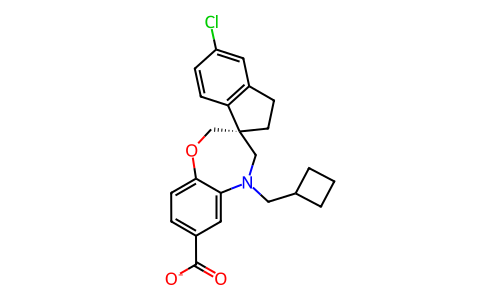

In [36]:
from openff.toolkit import Molecule

# Load a molecule from a SDF file
ligand = Molecule.from_file(ligand_path)

# Print out a SMILES code for the ligand
print(ligand.to_smiles(explicit_hydrogens=False))

# Visualize the molecule
ligand.visualize(show_all_hydrogens=False)

Conventionally, SDF files are used for ligands and PDB files are used for proteins. The toolkit loads polymers (including biopolymers such as proteins) via PDB files by inferring chemical information from the file and a known dictionary of common residues (and water, and ions). To do this, we'll use `Topology.from_pdb`

In [37]:
from openff.toolkit import Topology

topology = Topology.from_pdb(receptor_path)

# Note that we have box vectors:
print(topology.box_vectors)

[[6.5199 0.0 0.0] [0.0 6.5199 0.0] [0.0 0.0 6.5199]] nanometer


We can add the ligand `Molecule` to the topology created from the protein PDB file.

In [ ]:
topology.add_molecule(ligand)

Now that we've assembled our topology, we can save it to disk. We can use JSON for this, which makes it human readable in a pinch. This stores everything we've just assembled - molecular identities, conformers, box vectors, and everything else. The topology can then be loaded later on with the [`Topology.from_json()`] method. This is great for running the same system through different force fields, distribution with a paper, or for assembling systems in stages.

[`Topology.from_json()`]: https://docs.openforcefield.org/projects/toolkit/en/stable/api/generated/openff.toolkit.topology.Topology.html#openff.toolkit.topology.Topology.from_json

In [ ]:
with open("topology.json", "w") as f:
    print(topology.to_json(), file=f)

To visualize inside the notebook, we'll use `Topology.visualize`, which uses NGLview under the hood. NGLview supports a wide variety of [molecular visualization methods], as well as a VMD-like [atom selection language]. This can be used to visualize complex systems like this one.

The widget consists of a minimally documented [Python library frontend] and an extensively documented [JavaScript backend]. You'll need to refer to the documentation for both to do anything sophisticated, as the Python code delegates most of its options and functionality to the JS code.

By default, the toolkit attemps to draw some components with special representations:
* Waters: [line](https://nglviewer.org/ngl/api/manual/molecular-representations.html#line)
* Ions: [spacefill](https://nglviewer.org/ngl/api/manual/molecular-representations.html#spacefill)
* Proteins: [cartoon](https://nglviewer.org/ngl/api/manual/molecular-representations.html#cartoon)

Everything else (i.e. unrecognized ligands) are drawn with the [licorice](https://nglviewer.org/ngl/api/manual/molecular-representations.html#licorice) representation, which is basically a ball+stick model. A box representing the periodic boundary conditions is also added.

[molecular visualization methods]: https://nglviewer.org/ngl/api/manual/molecular-representations.html
[atom selection language]: https://nglviewer.org/ngl/api/manual/selection-language.html
[Python library frontend]: https://nglviewer.org/nglview/latest/api.html
[JavaScript backend]: https://nglviewer.org/ngl/api/manual/index.html

In [ ]:
view = topology.visualize()

# can make further modifications to this representation object, or just look at it
view

<div class="alert alert-info" style="max-width: 700px; margin-left: auto; margin-right: auto;">
ℹ️ Have a play with this visualization! Try clearing the default representations with <code>view.clear()</code> and configuring your own cartoon <em>(Hint: <a href=https://nglviewer.org/nglview/latest/api.html#nglview.NGLWidget>Check</a> the <a href=https://nglviewer.org/ngl/api/manual/molecular-representations.html>docs</a>)</em>. See if you can display the ligand in a way you like. When you're happy with what you've made, save the image with <code>view.download_image()</code>
</div>

## 3. We Can Assemble a Combined `ForceField` and use this to Parameterise the Whole System

Now that we've prepared our co-ordinates, we should choose the force field. For now, we don't have any single SMIRNOFF force field that can handle both proteins and small molecules; the Rosemary 3.0.0 force field will support this, but it's not yet ready. As an alternative, we'll combine the [Sage] small molecule force field with the SMIRNOFF port of Amber ff14SB. These force fields parameterise non-bonded parameters in similar ways and with the same functional form, so we don't expect any outrageous artifacts, but they also haven't been carefully tested together (TODO: Still true?). Note that Sage also includes the TIP3P water model, which is appropriate for Amber ff14SB too.

When we combine multiple SMIRNOFF force fields into one, we provide them in an order from general to specific. Sage includes parameters that could be applied to a protein, but they're general across all molecules; ff14SB's parameters are specific to proteins. Since the Toolkit always applies the last parameters that match a moiety, this order makes sure the right parameters get assigned.

[Sage]: https://openforcefield.org/force-fields/force-fields/#sage

<div class="alert alert-warning" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    🚧 <b> This code is not production-ready</b><br />
The Amber ff14SB port is intended as a proof-of-concept for SMIRNOFF protein force fields. It may not precisely match the energetics or forces of the original ff14SB, and it may not be appropriate in combination with Sage. Wait for protein support in the Rosemary force field to use this in production. 
</div>


In [120]:
from openff.toolkit import ForceField

# Assemble the combined force field
sage_ff14sb = ForceField("openff-2.2.1.offxml", "ff14sb_off_impropers_0.0.3.offxml")

We now have a `Topology`, which stores the chemical information of the system, and a `ForceField`, which maps chemistry to force field parameters. To parametrize the system, we combine these two objects into an [`Interchange`], as discussed in this morning's session.

An `Interchange` represents a completely parametrized molecular mechanics system. Partial charges are computed here according to the instructions in the force field, and this is where virtual sites required by the force field will be introduced. This all happens behind the scenes; all we have to do is combine an abstract chemical description with a force field. This makes it easy to change water model or force field, as the chemistry being modelled is completely independent of the model itself.

[`Interchange`]: https://docs.openforcefield.org/projects/interchange/en/stable/_autosummary/openff.interchange.components.interchange.Interchange.html

In [121]:
interchange = sage_ff14sb.create_interchange(topology)

*(This should take about a minute, largely because of the complexity of the Amber protein force field port. In the future, this should be faster.)*

While that runs, let's recap. We've constructed a `Topology` out of a number of `Molecule` objects, each of which represents a particular chemical independent of any model details. The `Topology` then represents an entire chemical system, which in theory could be modelled in any number of ways. Our `Topology` also includes atom positions and box vectors, but if we thought that was too concrete for our use case we could leave them out and add them after parametrization.

Separately, we've constructed a `ForceField` by combining a general SMIRNOFF force field with a protein-specific SMIRNOFF force field. A SMIRNOFF force field is a bunch of rules for applying force field parameters to chemicals via SMARTS patterns. The force field includes everything needed to compute an energy: parameters, charges, functional forms, non-bonded methods and cutoffs, virtual sites, and so on.

Then, we've parametrized our `Topology` with our `ForceField` to produce an `Interchange`. This applies all our rules and gives us a system ready to simulate. An `Interchange` can also concretely define positions, velocities, and box vectors, whether they come from the `Topology` or are added after parametrization. Once we have the `Interchange`, we can produce input data for any of the supported MM engines.

This clear delineation makes benchmarking the same system against different force fields or the same force field against different force fields easy. The SMIRNOFF format makes distributing force fields in an engine agnostic way possible. Everything is an open standard or written in open source Python, so we can see how it works and even change it if we need to.

## 3 We can Simulate the Dynamics of the Complex with OpenMM

To use an `Interchange`, we need to convert it to the input expected by a particular molecular mechanics engine. We'll use OpenMM, because its support is the most mature and the fastest, but GROMACS, LAMMPS, and Amber all enjoy [preliminary support]. (TODO: Still preliminary?)

All that remains is to tell OpenMM the details about how we want to integrate and record data for the simulation, and then to put everything together and run it! The steps are:

1. Configure and run the simulation
1. Minimise the combined system
1. Run a short simulation
1. Visualise the trajectory

[preliminary support]: https://docs.openforcefield.org/projects/interchange/en/stable/using/output.html

### 3.1 Configure and run the simulation

Here, we'll use a Langevin thermostat at 300 Kelvin and a 2 fs time step. We'll write the structure to disk every 10 steps.

In [ ]:
import openmm

# Construct and configure a Langevin integrator at 300 K with an appropriate friction constant and time-step
integrator = openmm.LangevinIntegrator(
    300 * openmm.unit.kelvin,
    1 / openmm.unit.picosecond,
    0.002 * openmm.unit.picoseconds,
)

# Under the hood, this creates *OpenMM* `System` and `Topology` objects, then combines them together
simulation = interchange.to_openmm_simulation(integrator=integrator)

# Add a reporter to record the structure every 50 steps
dcd_reporter = openmm.app.DCDReporter("trajectory.dcd", 50)
pdb_reporter = openmm.app.PDBReporter("trajectory.pdb", 50)
simulation.reporters.append(dcd_reporter)

### 3.2 Minimise the combined system

This will reduce any forces that are too large to integrate, such as from clashes or from disagreements between the crystal structure and force field.


In [123]:
def describe_state(state: openmm.State, name: str = "State"):
    max_force = max(numpy.sqrt(v.x**2 + v.y**2 + v.z**2) for v in state.getForces())
    print(
        f"{name} has energy {round(state.getPotentialEnergy()._value, 2)} kJ/mol "
        f"with maximum force {round(max_force, 2)} kJ/(mol nm)"
    )


describe_state(
    simulation.context.getState(
        getEnergy=True,
        getForces=True,
    ),
    "Original state",
)

simulation.minimizeEnergy()

describe_state(
    simulation.context.getState(getEnergy=True, getForces=True),
    "Minimized state",
)

Original state has energy -842649.75 kJ/mol with maximum force 49813.79 kJ/(mol nm)


Minimized state has energy -1156618.87 kJ/mol with maximum force 2694.45 kJ/(mol nm)


### 3.3 Run a short simulation

If this were anything more than a demonstration of the Toolkit, this example would need to include additional steps like equilibration. 

<div class="alert alert-warning" style="max-width: 700px; margin-left: auto; margin-right: auto;">
⚠️ Make sure you use your own, valid simulation protocol! This is just an example.
</div>

In [124]:
simulation.context.setVelocitiesToTemperature(300 * openmm.unit.kelvin)
simulation.runForClockTime(1.0 * openmm.unit.minute)

_(This'll take a minute - literally, this time)_

While that runs, let's talk a bit about OpenFF (TODO: Link to discussion of OpenFF from previous notebook and remove this?)

### Open Source Force Fields

A primary goal of the Open Force Field Initiative is to make development and use of force fields as open as possible - it's in our name! We believe that open source development practices have a lot to offer the scientific community, whether that science is academic, commercial, or hobbyist.

#### The SMIRNOFF specification

The SMIRNOFF specification describes a simple format for describing molecular force fields. We provide and maintain this spec in the hopes that it will allow scientists everywhere to contribute to force field development in a unified way, without taking them away from their favourite simulation package.

SMIRNOFF is not just a spec; we're also committed to a reference implementation — that being the OpenFF Toolkit. The Toolkit endeavors to support all the functional forms in both the SMIRNOFF spec and the [`openff-forcefields`](https://github.com/openforcefield/openff-forcefields/) package.

#### Reproducibility

OpenFF force fields are completely specified by the name of the distributed `.offxml` file. We use codenames, version numbers, and tags to accomplish this. This means that as long as a user, designer, or reviewer sees the name of the force field being used, they know exactly what is going in to that simulation. We include parameters that are often neglected in force field specifications, such as the non-bonded cut-off distance, ewald methods, constraints, modifications to the Lennard-Jones function, and partial charge generation methods are all defined by the name of the force field. 

As much as possible, we want energy and force to be a deterministic output of combining a molecule and a force field. If an author provides the name of the force field in their methods section, it should be reproducible. The other side of this coin is that we never want to hide the force field from the user. In all our workflows, the name of the force field must be explicitly provided in the code. This improves reproducibility of the code and helps the user take responsibility for their results. 

#### "Plugin" support for new force fields

The OpenFF Toolkit supports distributing force field files (.offxml) through Conda data packages. Anyone can publish a package on Conda Forge that extends the list of directories the toolkit searches for force fields, allowing anyone to produce force fields without requiring their own tooling, in a format that is designed to be converted to a multitude of simulation packages. See the [FAQ](https://open-forcefield-toolkit.readthedocs.io/en/stable/faq.html#how-can-i-distribute-my-own-force-fields-in-smirnoff-format) for more details.

---

Right! Simulation should be done by now, let's take a look.

### 3.4 Visualize the simulation with nglview

NGLView can display single structures and entire trajectories. Mouse over the widget to see the animation controls.

<div class="alert alert-warning" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    ❓ Can you visualize this trajectory in VMD (or another visualization tool of your choice)? Hint: DCD files only include the trajectory data (positions of each atoms over time) and lack topological information, so you might need another file.
</div>

In [61]:
import mdtraj

trajectory: mdtraj.Trajectory = mdtraj.load(
    "trajectory.dcd", top=mdtraj.Topology.from_openmm(interchange.to_openmm_topology())
)

view = nglview.show_mdtraj(trajectory.image_molecules())
view.add_representation("line", selection="protein")
view

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


NGLWidget(max_frame=736)

<div class="alert alert-info" style="max-width: 700px; margin-left: auto; margin-right: auto;">
ℹ️ MDTraj is a great library for analysis. Check out the <a href=https://mdtraj.org/1.9.4/api/generated/mdtraj.Trajectory.html>docs</a> for the <code>Trajectory</code> object you just created, as well as their <a href=https://mdtraj.org/1.9.4/analysis.html>analysis functions</a>, and see if you can compute something interesting. Its real superpower is that it provides the coordinates of the trajectory as a <a href=https://numpy.org/doc/stable/reference/generated/numpy.array.html>NumPy array</a>, so if you're really keen try computing something directly from <code>mdt_traj.xyz</code>
</div>

## 4. MDTraj enables analysis of pose stability and protein-ligand interactions

TODO: Add more description.

Analyses would be:

1. Assessment of pose stability based on RMSD of the ligand in the frame of reference of the binding site
1. Protein-ligand interaction analysis

Another option: Use ProLIF to generate nice interaction fingerprint/ plots. Can't get this working at the moment (no interactions detected...) and would requie the use of MDAnalysis rather than MDTraj (which was the agreed analysis tool).

In [ ]:
# TODO: Add code

## 5. Conclusions

* The OpenFF workflow cleanly separates the chemical system from its model.
* We parametrize ligands and proteins with the same software tools.
* Open source tools installed via Conda did everything, from basic system prep to simulation and visualization
* Using OpenMM, we never had to leave Python to set up the simulation
* With Interchange, using OpenMM, GROMACS, Amber or LAMMPS is simple!
* MDTraj allows us to perform varied analyses of our trajectories

## 6. There's Lots More to OpenFF!

A variety of example notebooks for OpenFF software are provided [here](https://docs.openforcefield.org/en/latest/examples.html). A few which are particularly relevant are:

- [Host-guest systems](https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-interchange/host-guest/host_guest.html)
- [Protein-ligand-water systems with Interchange](https://docs.openforcefield.org/en/latest/examples/openforcefield/openff-interchange/protein_ligand/protein_ligand.html). This has a lot of overlap with the current notebook, but there are several extra details not covered here.

## 7. Beyond OpenFF

You can parameterise your complex and run molecular dynamics -- so what's next? If you're interested in quantiatively assessing the binding affinity of your ligand for your target, then [alchemical (and path-based) free energy calculations are the gold-standard method](https://www.nature.com/articles/s42004-023-01019-9). [Open Free Energy](https://openfree.energy/) is another [Open Molecular Software Foundation](https://omsf.io/) initiative, which develops open-source tools for binding free energy calculations. Head to their [tutorials](https://docs.openfree.energy/en/latest/tutorials/index.html) to learn more! However, these calculations are computationally demanding. If you're interested in a relatively fast (but relatively inaccurate) ranking of the binding affinities of a set of ligands, methods such as MM/GBSA may be appropriate (see the upcoming tutorial).